In [0]:
import roboschool
import gym
import numpy as np
import torch
import math
import random
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
env_name = "RoboschoolWalker2d-v1"
env = gym.make(env_name)

np.random.seed(10)

hl_size = 100
h2_size = 40
version = 2
npop = 50
sigma = 0.2
alpha = 0.03
iter_num = 300
aver_reward = None
allow_writing = True
reload = False

print(hl_size, version, npop, sigma, alpha, iter_num)

print("class_name: {} \naction_space: {} \nobservation_space: {} \nreward_range {}".format(env.class_name,
                                                                                       env.action_space, 
                                                                                       env.observation_space, 
                                                                                       env.reward_range))

100 2 50 0.2 0.03 300
class_name: <bound method Wrapper.class_name of <class 'gym.wrappers.time_limit.TimeLimit'>> 
action_space: Box(6,) 
observation_space: Box(22,) 
reward_range (-inf, inf)


In [0]:
model = {}
model['W1'] = np.random.randn(22, hl_size) / np.sqrt(22)
model['W2'] = np.random.randn(hl_size, h2_size) / np.sqrt(hl_size)
model['W3'] = np.random.randn(h2_size, 6) / np.sqrt(h2_size)


In [0]:
def get_action(state, model):
    h1 = np.matmul(state, model['W1'])
    h1 = np.tanh(h1)
    h2 = np.matmul(h1, model['W2'])
    h2 = np.tanh(h2)
    action = np.matmul(h2, model['W3'])
    action = np.tanh(action)

    return action

def f(model, render=False):
    state = env.reset()
    total_reward = 0
    for t in range(iter_num):
        if render: env.render()

        action = get_action(state, model)
        state, reward, done, info = env.step(action)
        total_reward += reward

        if done:
            break
    return total_reward

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


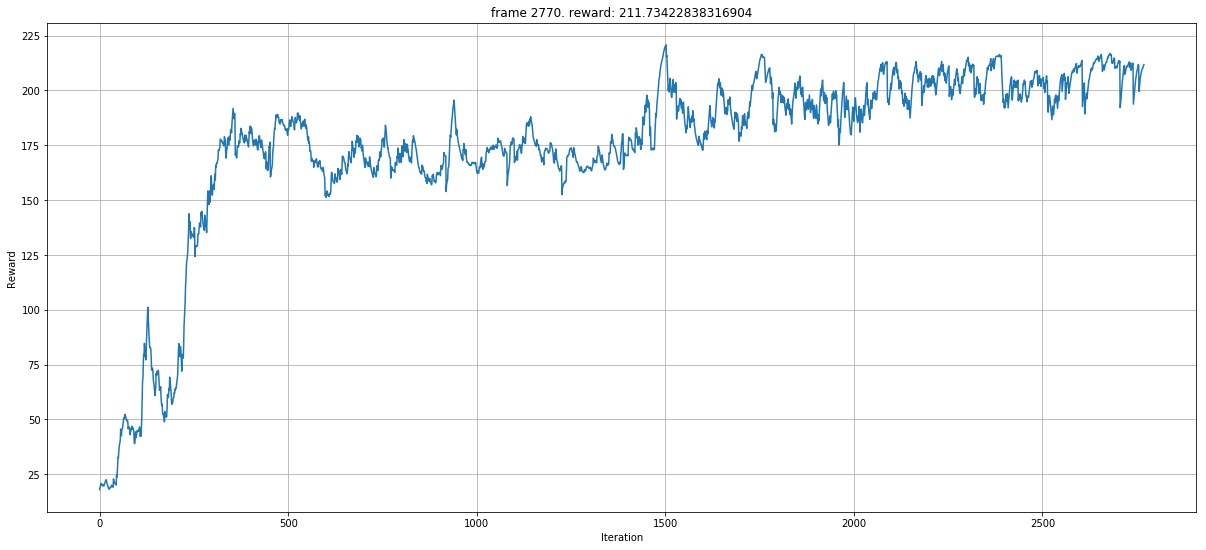

KeyboardInterrupt: ignored

In [8]:
PATH = "/content/gdrive/My Drive/ML-DL/RL/"
version = 3

def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(70,9))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.ylabel("Reward")
    plt.xlabel("Iteration")
    plt.plot(rewards)
    plt.grid()
    plt.show()
    #if self.savefig and frame_idx % self.save_frequency == 0 : 
    #  plt.savefig(self.save_dir + "PPO_A2C_rewards.png")
        
rewards = []

for i in range(1, 10001):
    N = {}
    for k, v in model.items():
        N[k] = np.random.randn(npop, v.shape[0], v.shape[1])
    R = np.zeros(npop)

    for j in range(npop):
        model_try = {}
        for k, v in model.items():
            model_try[k] = v + sigma*N[k][j]
        R[j] = f(model_try)

    A = (R - np.mean(R)) / np.std(R)
    for k in model:
        model[k] = model[k] + alpha/(npop*sigma) * np.dot(N[k].transpose(1, 2, 0), A)

    cur_reward = f(model)
    aver_reward = aver_reward * 0.9 + cur_reward * 0.1 if aver_reward != None else cur_reward
    
    rewards.append(aver_reward)
    
    if i % 10 == 0:
        plot(i, rewards)
    
    
    #print('iter %d, cur_reward %.2f, aver_reward %.2f' % (i, cur_reward, aver_reward))

    if i % 10 == 0 and allow_writing:
        torch.save(model, PATH + 'model-bipedal{}.pt'.format(version) )